# setup


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
os.environ["OMP_NUM_THREADS"] = '1'
from glob import glob
import seaborn as sns
import geopandas as gpd
import xarray as xr
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import rioxarray
from scipy.stats import entropy


In [2]:
ibge = gpd.read_file(r'Data\IBGE\BiomasBrasil.shp')
shp_cerrado = ibge[ibge.biomas == 'CERRADO']
gdf = gpd.read_file('Data\stations.geojson').to_crs(ibge.crs)
df_cerrado = pd.read_pickle(r'Data\df_cerrado_bet.pkl')
gdf_filtered = gdf[gdf.Code.isin(df_cerrado.Code.unique())]

FileNotFoundError: [Errno 2] No such file or directory: '\\Data\\df_cerrado_bet.pkl'

# metrics

In [4]:
#calculate MAP
dff_map = df_cerrado.groupby(['Code']).mean(numeric_only=True) * 12
dff_map.reset_index(inplace=True)
df_metrics = dff_map.copy().rename({'Total': 'MAP'},  axis='columns')

In [5]:
#calculate metrics for dry and wet season
df_dryy = df_cerrado[df_cerrado['Total'] <= 100]
df_metrics['dsl'] = df_dryy.groupby(['Code', df_dryy.Date.dt.year]).size().groupby('Code').mean().reset_index().rename({0: 'dsl'},  axis='columns')['dsl']
df_metrics['dsl_std'] = df_dryy.groupby(['Code', df_dryy.Date.dt.year]).size().groupby('Code').std().reset_index().rename({0: 'dsl_std'},  axis='columns')['dsl_std']
df_metrics['dsl_cv'] = df_metrics['dsl_std'] / df_metrics['dsl']
df_metrics['dry_precip'] = (df_dryy.groupby(['Code']).sum(numeric_only=True) / 30).reset_index().rename({'Total': 'dry_precip'},  axis='columns')['dry_precip']
df_metrics['dry_precip_std'] = (df_dryy.groupby(['Code', df_dryy.Date.dt.year]).sum(numeric_only=True).groupby('Code').std()).reset_index().rename({'Total': 'dry_precip_std'},  axis='columns')['dry_precip_std']
df_metrics['dry_precip_cv'] = df_metrics['dry_precip_std'] / df_metrics['dry_precip']
#wet
df_wett = df_cerrado[df_cerrado['Total'] > 100]
df_metrics['wet_precip'] = (df_wett.groupby(['Code']).sum(numeric_only=True) / 30).reset_index().rename({'Total': 'wet_precip'},  axis='columns')['wet_precip']
df_metrics['wet_precip_std'] = (df_wett.groupby(['Code', df_wett.Date.dt.year]).sum(numeric_only=True).groupby('Code').std()).reset_index().rename({'Total': 'wet_precip_std'},  axis='columns')['wet_precip_std']
df_metrics['wet_precip_cv'] = df_metrics['wet_precip_std'] / df_metrics['wet_precip']
df_cerrado = df_cerrado.sort_values(by=['Code', 'Date']).reset_index(drop=True)

In [7]:
# MSI CALCUATION
weights = (np.pi/6, np.pi/3, np.pi/2, 2*np.pi/3, 5*np.pi/6, np.pi, 7*np.pi/6, 4*np.pi/3, 3*np.pi/2, 5*np.pi/3, 11*np.pi/6, 2*np.pi)
df_test = df_cerrado.copy()
#df_test
msi_an = []
for i in range(0, len(df_test)//12):
    precyr = []
    aux1 = []
    aux2 = []
    for j in range(0, 12):
        aux = 12*(i)+j
        #print(aux)

        aux1.append(np.sin(weights[j]) * df_test['Total'][aux])
        aux2.append(np.cos(weights[j]) * df_test['Total'][aux])
        precyr.append(df_test['Total'][aux])

    aux1sum = np.array(aux1).sum()    
    aux2sum = np.array(aux2).sum()
    mag_yr = np.sqrt(aux1sum**2 + aux2sum**2)
    mp_yr = np.array(precyr).sum()
    msi_yr = mag_yr / mp_yr
    msi_an.append(msi_yr)




In [ ]:
df_years = df_cerrado.groupby(['Code', df_cerrado.Date.dt.year]).apply(lambda x: x['Total'].sum()).reset_index().rename({0: 'Total'},  axis='columns')
df_years['msi'] = msi_an
df_metrics['msi'] = df_years.groupby(['Code']).mean(numeric_only=True).reset_index()['msi']

## entropy


In [5]:
#calculate Relative Entropy
df_cerrado = df_cerrado.sort_values(by=['Code', 'Date']).reset_index(drop=True)
pp_monthly = df_cerrado.groupby(['Code', df_cerrado.Date.dt.month]).mean(numeric_only=True).reset_index().rename({'Date': 'Month'},  axis='columns')
pp_monthly['Ratio'] = pp_monthly['Total'] / pp_monthly.groupby('Code')['Total'].transform('sum')
# create a uniform distribution
uniform = np.zeros(12)
uniform[:] = 1/12
# aplly the entropy function to the ratio column for each code
df_metrics['Entropy'] = pp_monthly.groupby('Code')['Ratio'].apply(lambda x: entropy(x, qk=uniform,base=2)).reset_index().rename({'Ratio': 'Entropy'},  axis='columns')['Entropy']

,Code,Month,Total,Ratio
0,343001,1,225.683333,0.136913
1,343001,2,252.923333,0.153438
2,343001,3,363.930000,0.220781
3,343001,4,321.740000,0.195187
4,343001,5,201.998419,0.122544
...,...,...,...,...
5731,2450036,8,64.506384,0.039899
5732,2450036,9,130.889192,0.080958
5733,2450036,10,134.410392,0.083136
5734,2450036,11,126.081471,0.077984


In [14]:
df_metrics.to_pickle(r'Data\df_metrics_bet.pkl')

# plots

In [3]:
df_metrics = pd.read_pickle('Data\df_metrics_bet.pkl', index_col=0)
gdf_metrics = gdf_filtered.merge(df_metrics, on='Code', how='left')


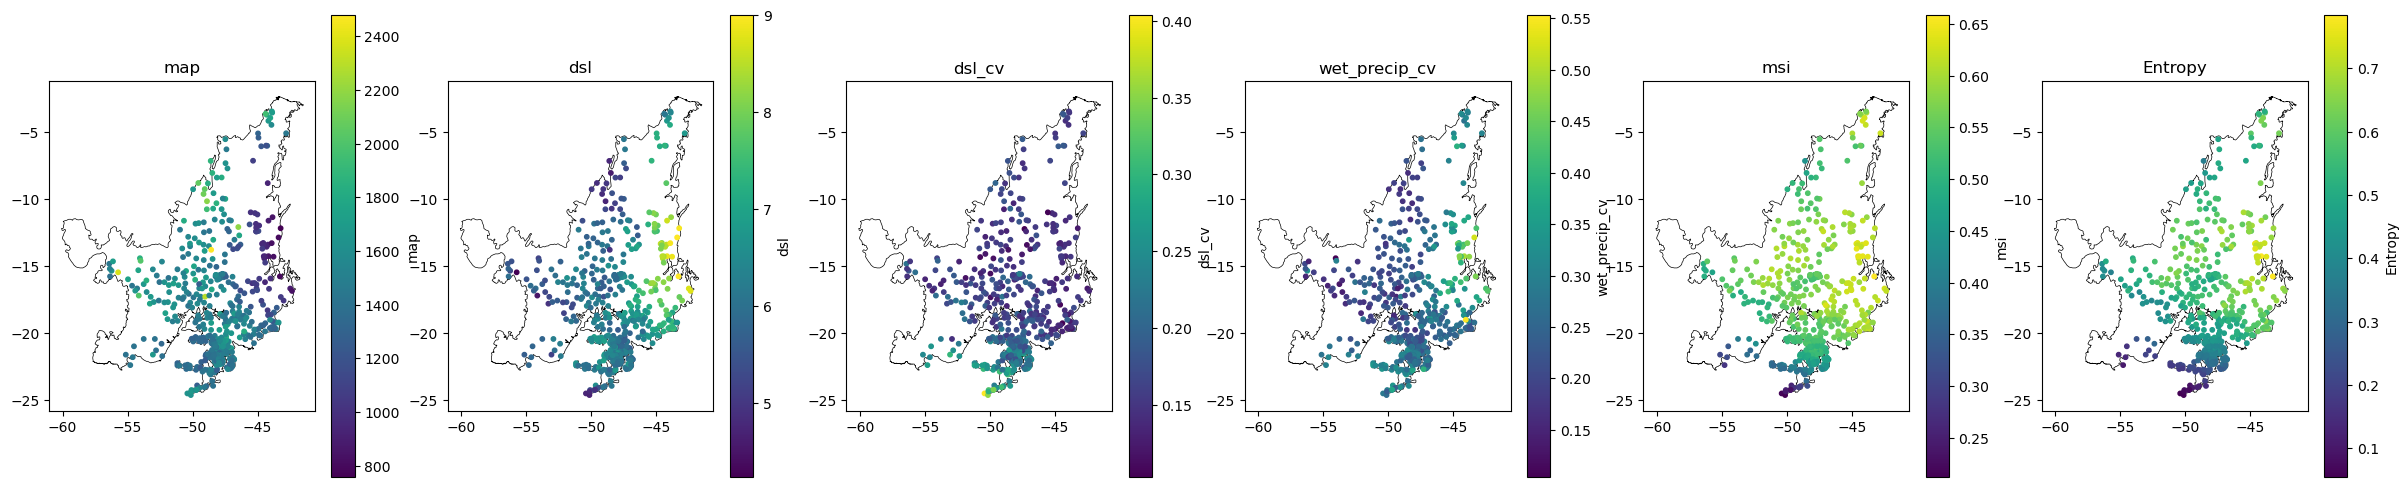

In [5]:
metrics = ['map', 'dsl', 'dsl_cv', 'wet_precip_cv', 'msi', 'Entropy']
fig, axes = plt.subplots(1, len(metrics), figsize=(30,6))
for i, metric in enumerate(metrics):
    shp_cerrado.plot(ax=axes[i], color='white', edgecolor='black', linewidth=0.5)
    gdf_metrics.plot(column=metric, ax=axes[i], legend=True, legend_kwds={'label': metric}, markersize=10)
    axes[i].set_title(metric)

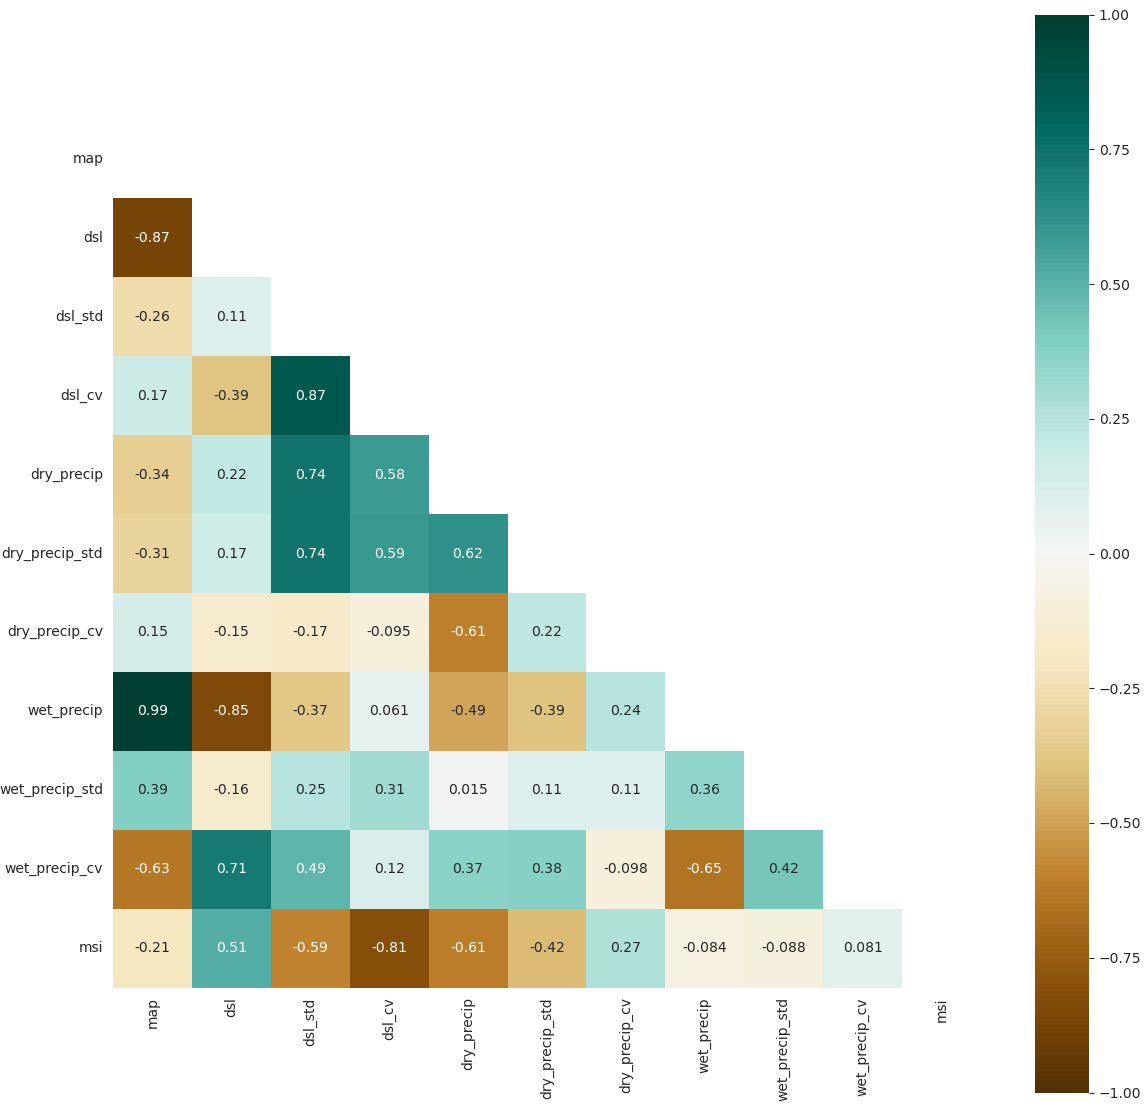

In [6]:
corr = df_metrics[['map', 'dsl', 'dsl_std', 'dsl_cv', 'dry_precip','dry_precip_std', 'dry_precip_cv', 'wet_precip', 'wet_precip_std','wet_precip_cv', 'msi']].corr()
#plot heatmap correlations
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(14, 14))
    ax = sns.heatmap(corr, mask=mask, square=True, vmin=-1, vmax=1, annot=True, cmap='BrBG')


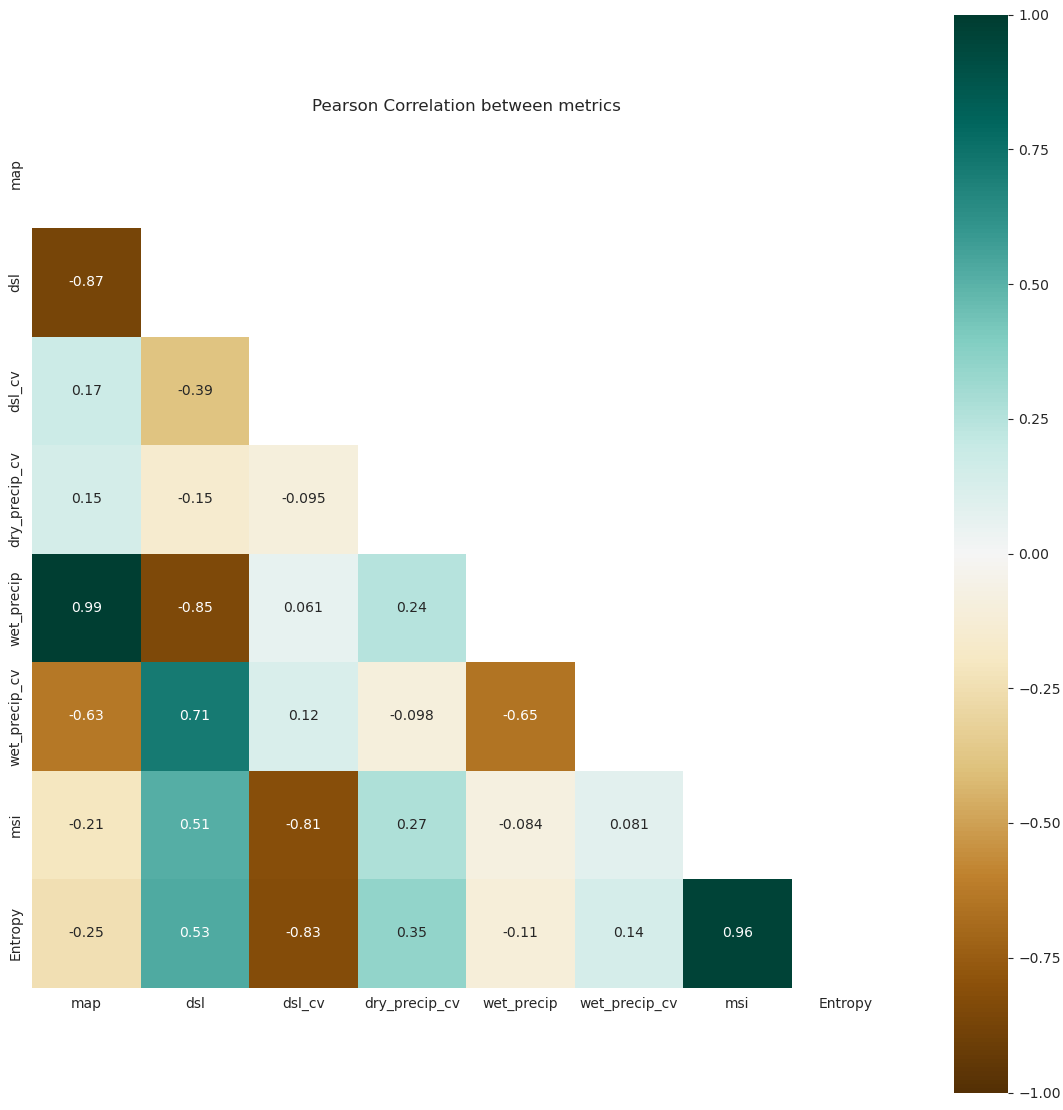

In [7]:
corr = df_metrics[['map', 'dsl',  'dsl_cv', 'dry_precip_cv', 'wet_precip', 'wet_precip_cv', 'msi', 'Entropy']].corr()
#plot heatmap correlations
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(14, 14))
    ax = sns.heatmap(corr, mask=mask, square=True, vmin=-1, vmax=1, annot=True, cmap='BrBG').set_title('Pearson Correlation between metrics')

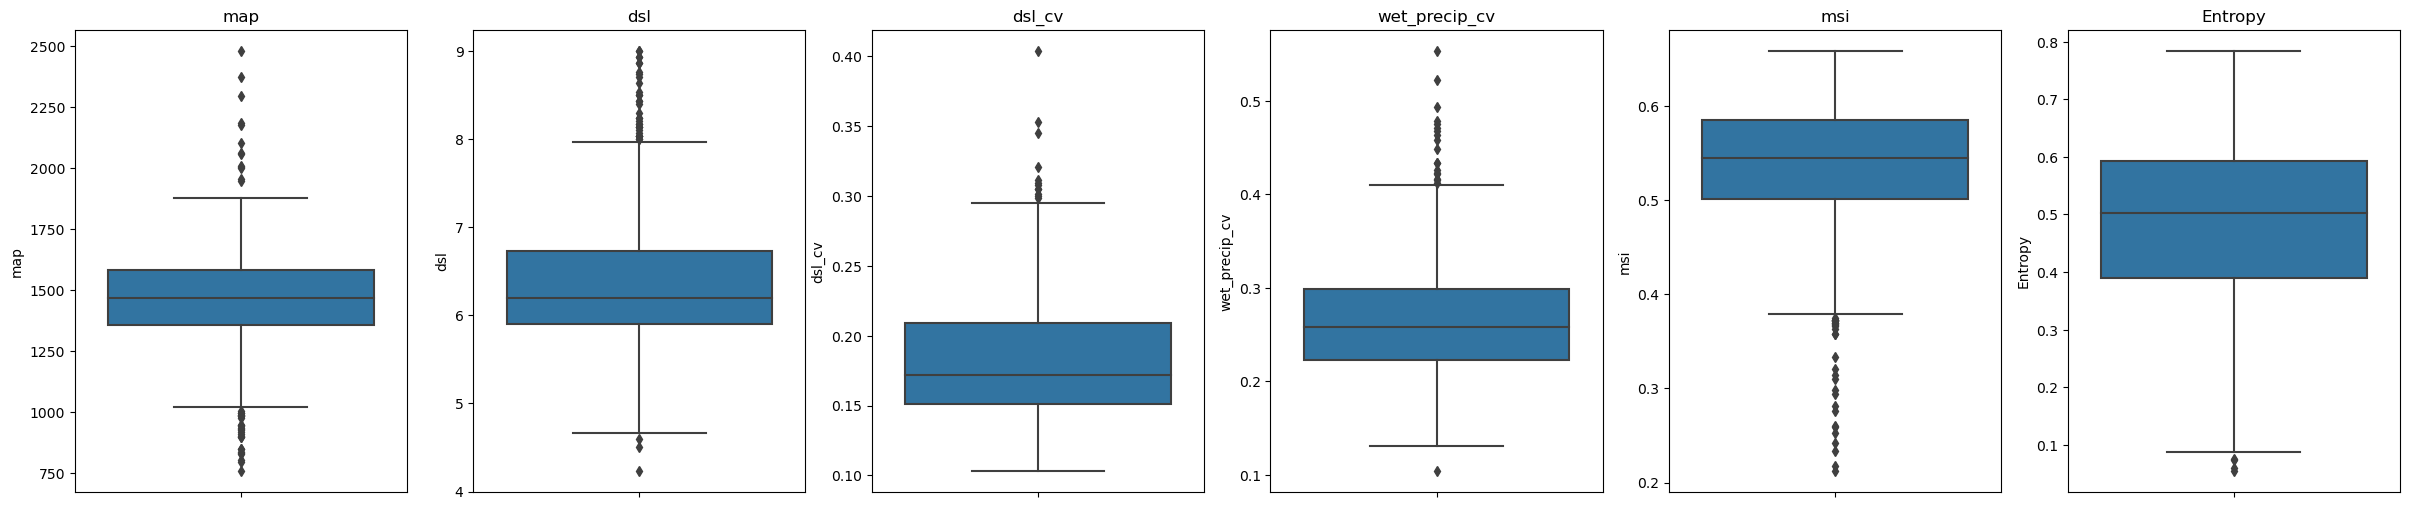

In [7]:
# plot boxplots of each metric
metrics = ['map', 'dsl', 'dsl_cv', 'wet_precip_cv', 'msi', 'Entropy']
fig, axes = plt.subplots(1, len(metrics), figsize=(30,6))
for i, metric in enumerate(metrics):
    sns.boxplot(y=metric, data=df_metrics, ax=axes[i])
    axes[i].set_title(metric)